I propose the **Automated Rainfall Dataset Evaluation (ARDE)** Model, a Python-based workflow for comparing station-level rainfall gauge data with multiple satellite and reanalysis products.

**Multiple rainfall data sources will be analyzed, including:**


*   IMD Gridded data
*   ERA5 Reanalysis - [link text](https://cds.climate.copernicus.eu/)
*   CHIRPS -[link text](https://www.chc.ucsb.edu/data/chirps)
*   GPM - IMERG - [link text](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGDF_07/summary?keywords=imerg%20daily)

**Other datasets which are not included in this study:**


*   GSMap ISRO Rain data
*   CHRS Persiann
*   Indian Monsoon Data Assimilation and Analysis (IMDAA)- [link text](https://rds.ncmrwf.gov.in/datasets)

The performance of these datasets will be validated against ground-based rain gauge observations obtained from **NWIC-IndiaWRIS** at selected sites within the basin.

In [ ]:
pip install -r requirements.txt

In [ ]:
import yaml, os

# Read YAML config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Extract paths
data_dir = cfg["data_dir"]
output_dir = cfg["output_dir"]
lat = cfg.get("lat", None)
lon = cfg.get("lon", None)
station_name = cfg.get("station_name", "Unknown Station")
start_date = cfg.get("start_date", None)
end_date = cfg.get("end_date",None)

# Create folders if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print("Data directory:", data_dir)
print("Output directory:", output_dir)
print(f"Station: {station_name} ({lat}, {lon})")
print(f"start_date: {start_date}, end_date: {end_date}")


# **IMD Gridded Rainfall Data (IMD4)**

| Attribute              | Details                                                                 |
|------------------------|-------------------------------------------------------------------------|
| **Product Name**       | IMD Gridded Rainfall Data (IMD 4)                                       |
| **Spatial Resolution** | 0.25° × 0.25° (~25 km × 25 km)                                          |
| **Spatial Coverage**   | Indian subcontinent; arranged as a 135 × 129 grid from ~6.5° N, 66.5° E to ~38.5° N, 100° E |
| **Temporal Coverage**  | 1901 – 2022 (ongoing updates available)|
| **Temporal Resolution**| Daily rainfall values in millimeters (mm) |
| **Number of Stations** | Based on data from ~6,955 rain gauge stations (highest in country) |
| **Data Latency**       | Typically ~3 days |
| **Data Format**        | NetCDF (.nc), with annual files per year (e.g., `RF25_indYYYY_rfp25.nc`) |
| **Key Features**       | Long-term, high-resolution daily rainfall reference for India; widely used for monsoon, agricultural, hydrological studies|


**Downloading and Extracting IMD Gridded Rainfall Data for a Specific Location**

This Python script uses the imdlib library to download daily IMD gridded rainfall data for 2022–2024, extracts the rainfall time series for the nearest grid point to Murappanaddu (lat: 8.7144, lon: 77.835), and saves it as a CSV file.

In [ ]:
import imdlib as imd

start_dy, end_dy = '2022-01-01', '2024-12-31'
var_type = 'rain'

imd_data_dir = os.path.join(data_dir, "IMD")
os.makedirs(imd_data_dir, exist_ok=True)

df_imd = imd.get_real_data(var_type, start_dy, end_dy, imd_data_dir)
df_imd.to_csv(f"imdlib_{start_dy[:4]}_{end_dy[:4]}.csv",
            lat=lat, lon=lon, out_dir=imd_data_dir)
print("csv file saved")

In [ ]:
ds=data.get_xarray()
print(len(ds.rain))

In [ ]:
ds = ds.where(ds['rain']!=-999.)
ds['rain'].mean('time').plot()

# **ERA5 Hourly Data on Single Levels - Total Precipitation**



| Attribute              | Details                                                                 |
|------------------------|-------------------------------------------------------------------------|
| **Product Name**       | ERA5 Hourly Data on Single Levels – Total Precipitation                 |
| **Coverage**| Global                                                                  |
| **Horizontal Resolution** | Atmosphere: 0.25° × 0.25°; Ocean waves: 0.5° × 0.5°                   |
| **Temporal Coverage**  | 1940 – present                                                          |
| **Temporal Resolution**| Hourly                                                                  |
| **File Format**        | GRIB or NetCDF                                                                   |
| **Update Frequency**   | Daily                                                                   |
| **Main Variable**      | Total precipitation (m of water equivalent)                             |
| **Variable Definition**| Accumulated liquid + frozen water (rain + snow) reaching Earth’s surface; sum of large-scale + convective precipitation. Excludes fog, dew, and evaporation before reaching surface. |
| **Units**              | metres of water equivalent                                              |


**Configuring CDS API Credentials for Data Access**

This code removes any existing .cdsapirc configuration file and creates a new one containing the Copernicus Climate Data Store (CDS) API URL and your personal access key, enabling authenticated downloads of climate datasets via the CDS API.

Note: To run this code, you must have a CDS API Access Key.

**How to get your key:**


1.   Create an account at https://cds.climate.copernicus.eu.
2.   Log in and go to your User Profile.
1.   Under the API key section, copy the provided url and key details.
2.   Replace the placeholder in the script with your actual key.


In [ ]:
import os

# Path for .cdsapirc in the user's home directory
cdsapirc_path = os.path.join(os.path.expanduser("~"), ".cdsapirc")

# Write CDS API config
with open(cdsapirc_path, 'w') as f:
    f.write("url: https://cds.climate.copernicus.eu/api\n")
    f.write("key: ea735c4e-d67d-481c-a32f-630a0afa9ba9\n")

print(f".cdsapirc file created at: {cdsapirc_path}")


**Downloading ERA5 Total Precipitation Data for a Specific Region and Period**

This Python script uses the cdsapi library to download ERA5 reanalysis total precipitation data (hourly, GRIB format) for the years 2022–2024 over a defined bounding box in southern India. The downloaded dataset is saved locally for further processing and analysis.

In [ ]:
import cdsapi
import os
import yaml

# --- Load YAML config ---
with open("config.yaml", "r") as f:  # Adjust path if needed
    cfg = yaml.safe_load(f)

data_dir = cfg["data_dir"]
lat = cfg["lat"]
lon = cfg["lon"]
start_dy = cfg["start_date"]
end_dy = cfg["end_date"]

# Create ERA5 output folder
era5_dir = os.path.join(data_dir, "ERA5")
os.makedirs(era5_dir, exist_ok=True)

# Extract years from start & end date
years = list(range(int(start_dy[:4]), int(end_dy[:4]) + 1))
years = [str(y) for y in years]

# Initialize CDS API client
c = cdsapi.Client()

# Download ERA5 data
c.retrieve(
    "reanalysis-era5-single-levels",
    {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "total_precipitation",
        "year": years,
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],
        "time": [f"{h:02d}:00" for h in range(24)],
        "area": [lat + 0.724, lon - 0.762, lat - 0.510, lon + 0.353],
    },
    os.path.join(era5_dir, f"era5_{start_dy[:4]}_{end_dy[:4]}.grib"),
)

print(f"ERA5 data saved to: {era5_dir}")


**Processing ERA5 GRIB Precipitation Data into Daily Rainfall (mm) and Saving as NetCDF**

This script reads ERA5 total precipitation data from a GRIB file using xarray with the cfgrib engine, converts units from meters to millimeters, computes actual timestamps from time and step variables, aggregates hourly values into daily totals, and saves the processed data as a NetCDF file for further analysis.

In [ ]:
import xarray as xr
import rioxarray

input_grib = os.path.join(data_dir, "ERA5", f"era5_{start_dy[:4]}_{end_dy[:4]}.grib")
output_nc = os.path.join(data_dir, "ERA5", f"era5_{start_dy[:4]}_{end_dy[:4]}.nc")

ds = xr.open_dataset(input_grib, engine="cfgrib")
tp = ds["tp"] * 1000
tp.name = "tp"
tp.attrs["units"] = "mm"

valid_time = (ds.time.values[:, None] + ds.step.values).flatten()
tp_stacked = tp.stack(z=('time', 'step')).transpose('z', 'latitude', 'longitude')
tp_stacked.coords['datetime'] = ('z', valid_time)

tp_time = tp_stacked.swap_dims({'z': 'datetime'}).sortby('datetime')
tp_daily = tp_time.resample(datetime='1D').sum().dropna('datetime', how='any')

tp_daily.to_netcdf(output_nc)
print(f"Saved daily rainfall in mm as NetCDF: {output_nc}")


**Extracting ERA5 Daily Rainfall for a Specific Location and Saving as CSV**

This script loads processed ERA5 daily rainfall data from a NetCDF file, extracts the time series for the nearest grid point to specified Location, converts it to a pandas DataFrame, and saves it as a CSV file.

In [ ]:
import xarray as xr
import pandas as pd
import os

# Load the NetCDF file
nc_file = os.path.join(data_dir, "ERA5", f"era5_{start_dy[:4]}_{end_dy[:4]}.nc")
csv_path = os.path.join(data_dir, "ERA5", f"era5_{start_dy[:4]}_{end_dy[:4]}.csv")

#Load NetCDF
ds = xr.open_dataset(nc_file)
tp = ds['tp']

# Extract nearest point (xarray handles interpolation via method="nearest")
tp_point = tp.sel(latitude=lat, longitude=lon, method="nearest")

# Convert to pandas DataFrame
df_era5 = tp_point.to_dataframe().reset_index()[["datetime", "tp"]]
df_era5.columns = ['Date', 'Rainfall_mm']

# Save CSV
df_era5.to_csv(csv_path, index=False)

print(f"CSV saved at: {csv_path}")


TypeError: 'Timestamp' object is not subscriptable

# **CHIRPS Daily: Climate Hazards Center InfraRed Precipitation With Station Data (v2.0 Final)**

| Attribute              | Details                                                                 |
|------------------------|-------------------------------------------------------------------------|
| **Product Name**       | CHIRPS Daily: Climate Hazards Center InfraRed Precipitation With Station Data (v2.0 Final) |
| **Horizontal Coverage**| Global (50° S to 50° N, all longitudes)                                 |
| **Horizontal Resolution** | 0.05° × 0.05° (~5.566 km)                                            |
| **Temporal Coverage**  | 1981-01-01 to Present                                               |
| **Temporal Resolution**| Daily                                                                   |
| **Units**              | mm/day                                                                  |
| **Data Sources**       | Combination of satellite observations, rain gauge data, and climatology from UCSB Climate Hazards Group |



**Downloading CHIRPS Daily Rainfall Data for a Specific Location Using Google Earth Engine**

This script uses the Google Earth Engine (GEE) Python API to retrieve CHIRPS daily precipitation data for 2022–2024 at the nearest grid point to a specified location (lat/lon). The data is resampled to 0.25° resolution, extracted for each day, stored in a pandas DataFrame, and saved as a CSV file for analysis.

**Note:** To run this code, you need a Google Earth Engine account and an active project ID.

**Procedure to get access:**



1.   Create a Google Account (if you don’t have one).
2.   Sign up for Google Earth Engine at https://signup.earthengine.google.com and wait for approval (usually 1–2 days).
1.   Once approved, go to the Google Cloud Console → https://console.cloud.google.com.
2.   Create a new project (or use an existing one) and note its Project ID.
1.  Enable Earth Engine API for your project in the Cloud Console.
2.  Install the earthengine-api Python package and authenticate using:

















In [ ]:
import ee
import pandas as pd
import yaml
import os

# Load YAML config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Extract parameters
data_dir = cfg["data_dir"]
output_dir = cfg["output_dir"]
lat = cfg["lat"]
lon = cfg["lon"]
start_date = cfg["start_date"]
end_date = cfg["end_date"]

# Create CHIRPS output folder
chirps_dir = os.path.join(data_dir, "CHIRPS")
os.makedirs(chirps_dir, exist_ok=True)

# Authenticate and Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="solid-altar-454711-g3")

# Point of interest
point = ee.Geometry.Point([lon, lat])

# Target resolution (in meters for ~0.25 degrees)
target_scale_m = 27750

# Load CHIRPS dataset
collection = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select("precipitation")
)

# Get list of images
image_list = collection.toList(collection.size())
n_images = image_list.size().getInfo()

# Extract values
dates, precip_values = [], []
for i in range(n_images):
    image = ee.Image(image_list.get(i))

    # Resample to 0.25 degree resolution
    resampled_image = (
        image.reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
        .reproject(crs="EPSG:4326", scale=target_scale_m)
    )

    # Date
    date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()

    # Precipitation value at point
    precip = resampled_image.reduceRegion(
        reducer=ee.Reducer.first(), geometry=point, scale=target_scale_m
    ).get("precipitation")
    precip_value = precip.getInfo() if precip else None

    dates.append(date)
    precip_values.append(precip_value)

# Save DataFrame
df_chirps = pd.DataFrame({"date": dates, "precipitation (mm/day)": precip_values})
csv_path = os.path.join(chirps_dir, f"chirps_{start_date[:4]}_{end_date[:4]}.csv")
df_chirps.to_csv(csv_path, index=False)

print(df_chirps)
print(f"CSV saved: {csv_path}")


# **GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF) at GES DISC**

| Attribute           | Details                                                                 |
|---------------------|-------------------------------------------------------------------------|
| **Product Name**    | GPM IMERG Final Precipitation L3 Daily 0.1° × 0.1° V07 (GPM_3IMERGDF)   |
| **Spatial Coverage**| Global (–90° to +90° latitude, –180° to +180° longitude)                |
| **Spatial Resolution** | 0.1° × 0.1° (~10 km × 10 km)                                          |
| **Temporal Coverage**| June 1, 2000 – ~February 28, 2025                                      |
| **Temporal Resolution**| Daily (aggregated from 30-minute estimates)                          |
| **Data Latency**    | ~4 months after month-end                                               |
| **Primary Variable**| Precipitation (mm/day)                                                  |
| **Other Variables** | precipitation_cnt, MWprecipitation_cnt, daily random error estimate    |
| **Units**           | mm/day                                                                  |
| **Data Source**     | NASA GES DISC (Final Run, gauge-adjusted, microwave + IR data)          |


**Downloading GPM IMERG Final Run Data Using Earthaccess**

This script authenticates with NASA Earthdata via the earthaccess library, searches for GPM IMERG Final Run (Version 07) precipitation data for a specified time range (2022–2024) and bounding box in southern India, and downloads the matching NetCDF files to a local directory.
Note: An active Earthdata account is required to run this code and complete the login process.

[How to Access GES DISC Data Using Python](https://disc.gsfc.nasa.gov/information/howto?keywords=python&title=How%20to%20Access%20GES%20DISC%20Data%20Using%20Python)

In [ ]:
import netCDF4 as nc4
import earthaccess
import xarray as xr
import pandas as pd
import os
import yaml

# --- Read YAML config ---
with open("config.yaml", "r") as f:  # adjust path if needed
    cfg = yaml.safe_load(f)

data_dir = cfg["data_dir"]
lat = cfg["lat"]
lon = cfg["lon"]

# Bounding box offsets for ~0.7° N/S and ~0.55° E/W (adjust if needed)
bbox = (lon - 0.55, lat - 0.7, lon + 0.55, lat + 0.7)

start_dy = cfg.get("start_date", "2022-01-01")
end_dy = cfg.get("end_date", "2024-12-31")

# Output directory for IMERG
imerg_dir = os.path.join(data_dir, "IMERG")
os.makedirs(imerg_dir, exist_ok=True)

# --- Authenticate with NASA Earthdata ---
auth = earthaccess.login()

# --- Search GPM IMERG Final Run data ---
results = earthaccess.search_data(
    short_name="GPM_3IMERGDF",
    version="07",
    temporal=(start_dy, end_dy),
    bounding_box=bbox
)

# --- Download the data ---
earthaccess.download(results, imerg_dir)

print(f"IMERG data downloaded to: {imerg_dir}")


**Extracting IMERG Precipitation Data for a Specific Location and Saving as CSV**

loading multiple IMERG .nc4 files to extract precipitation data for the nearest grid point to Murappanaddu. the extracted points are converted into Pandas data frame and saved as csv file

In [ ]:
import xarray as xr
import pandas as pd
import glob
import os
import yaml

# --- Load YAML config ---
with open("config.yaml", "r") as f:  # Adjust path if config.yaml is elsewhere
    cfg = yaml.safe_load(f)

data_dir = cfg["data_dir"]
lat = cfg["lat"]
lon = cfg["lon"]
station_name = cfg.get("station_name", "Unknown_Station")
start_dy = cfg["start_date"]
end_dy = cfg["end_date"]

# --- Path to IMERG folder ---
imerg_dir = os.path.join(data_dir, "IMERG")

# Get sorted list of .nc4 files
nc_files = sorted(glob.glob(os.path.join(imerg_dir, "*.nc4")))
if not nc_files:
    raise FileNotFoundError(f"No .nc4 files found in {imerg_dir}")

print(f"Found {len(nc_files)} IMERG files.")

# Prepare list for results
records = []

# Process each file safely
for i, file in enumerate(nc_files, start=1):
    try:
        ds = xr.open_dataset(file)

        # Extract precipitation variable at nearest grid point
        point_data = ds['precipitation'].sel(lat=lat, lon=lon, method='nearest')

        # Convert to pandas DataFrame
        df_temp = point_data.to_dataframe().reset_index()
        df_temp = df_temp.rename(columns={'time': 'Date', 'precipitation': 'Rainfall_mm'})

        records.append(df_temp)
        ds.close()

        if i % 100 == 0 or i == len(nc_files):
            print(f"Processed {i}/{len(nc_files)} files...")

    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Concatenate all results
df_imerg = pd.concat(records, ignore_index=True)

# Sort by date (optional, ensures correct order)
df_imerg = df_imerg.sort_values(by="Date").reset_index(drop=True)

# Save to CSV
output_csv_filename = os.path.join(imerg_dir, f"imerg_{station_name}_{start_dy[:4]}_{end_dy[:4]}.csv")
df_imerg.to_csv(output_csv_filename, index=False)

print(f"IMERG data for {station_name} saved to: {output_csv_filename}")


Found 1096 IMERG files.
Error processing file E:\ARDE Model\data\IMERG\3B-DAY.MS.MRG.3IMERG.20220304-S000000-E235959.V07B.nc4: [Errno -101] NetCDF: HDF error: 'E:\\ARDE Model\\data\\IMERG\\3B-DAY.MS.MRG.3IMERG.20220304-S000000-E235959.V07B.nc4'
Processed 100/1096 files...
Processed 200/1096 files...
Processed 300/1096 files...
Processed 400/1096 files...
Error processing file E:\ARDE Model\data\IMERG\3B-DAY.MS.MRG.3IMERG.20230428-S000000-E235959.V07B.nc4: [Errno -101] NetCDF: HDF error: 'E:\\ARDE Model\\data\\IMERG\\3B-DAY.MS.MRG.3IMERG.20230428-S000000-E235959.V07B.nc4'
Processed 500/1096 files...
Error processing file E:\ARDE Model\data\IMERG\3B-DAY.MS.MRG.3IMERG.20230731-S000000-E235959.V07B.nc4: [Errno -101] NetCDF: HDF error: 'E:\\ARDE Model\\data\\IMERG\\3B-DAY.MS.MRG.3IMERG.20230731-S000000-E235959.V07B.nc4'
Processed 600/1096 files...
Processed 700/1096 files...
Processed 800/1096 files...
Processed 900/1096 files...
Processed 1000/1096 files...
Processed 1096/1096 files...
IME

# **NWIC-IndiaWRIS**

| Attribute                | Details                                                                 |
|--------------------------|-------------------------------------------------------------------------|
| **Data Source**          | NWIC – India Water Resources Information System (India-WRIS)            |
| **Managed By**           | National Water Informatics Centre (NWIC), Ministry of Jal Shakti, Govt. of India|
| **Rainfall Data Type**   | Rain gauge time-series (live), covering daily rainfall from 1901 to present|
| **Spatial Coverage**     | Pan-India, across a dense network of central and state rain gauge stations|
| **Temporal Coverage**    | 1901 – present (continuously updated) |
| **Update Frequency**     | Real-time / live updates via WIMS platform|
| **Access Platform**      | Data entered via WIMS (Water Information Management System) by central and state agencies, visualized and downloadable via India-WRIS portal|


**Processing and Visualizing NWIC Rainfall Data from Raw SRG Measurements**

This script processes rainfall data from NWIC-IndiaWRIS station CSVs by filtering Manual SRG (Standard Rain Gauge) readings, aggregating them into daily totals, and saving them as a clean CSV file.

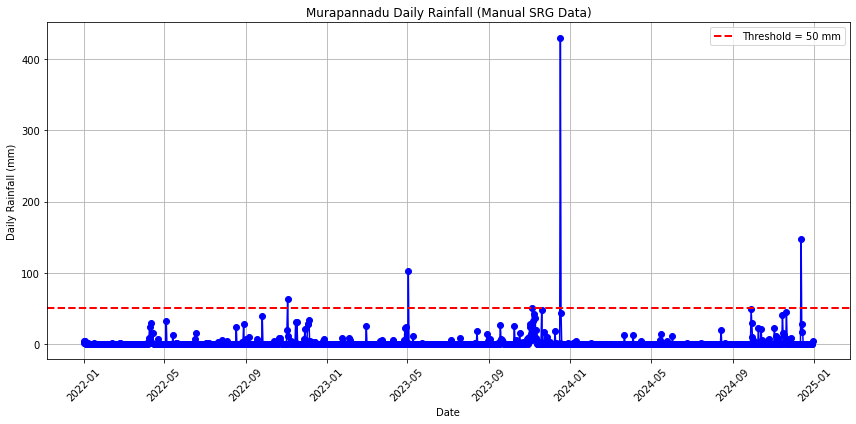

Full daily rainfall CSV saved to: E:\ARDE Model\data\NWIC\nwic_Murapannadu_2022_2024.csv
Rainfall time series plot saved to: E:\ARDE Model\data\NWIC\Rainfall_Murapannadu_Plot.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml

# --- Load YAML config ---
config_path = r"config.yaml"  # full path to config.yaml
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

station_name = cfg.get("station_name", "Unknown_Station")
start_dy = pd.to_datetime(cfg["start_date"])
end_dy = pd.to_datetime(cfg["end_date"])

# --- Paths ---
base_dir = os.path.dirname(config_path)  # E:\ARDE Model
input_csv_path = os.path.join(base_dir, "Rainfall_Murappanadu.csv")  # your original NWIC CSV
output_dir = os.path.join(cfg["data_dir"], "NWIC")
os.makedirs(output_dir, exist_ok=True)

output_csv_path = os.path.join(output_dir, f"nwic_{station_name}_{start_dy.year}_{end_dy.year}.csv")
plot_output_path = os.path.join(output_dir, f"Rainfall_{station_name}_Plot.png")

# --- Read and process ---
df_nwic = pd.read_csv(input_csv_path, skiprows=6)

df_nwic.rename(columns={'Time': 'Data Time', 'Value': 'Data Value'}, inplace=True)
df_nwic = df_nwic[df_nwic['Data Type Description'] == 'MANUAL-Rainfall - SRG(Standard Rain Gauge)']  # Filter SRG data
df_nwic['Data Time'] = pd.to_datetime(df['Data Time'])

# Filter date range from YAML
df_nwic = df_nwic[(df['Data Time'] >= start_dy) & (df['Data Time'] <= end_dy)]

df_nwic['Date'] = df_nwic['Data Time'].dt.date
df_nwic = df.groupby('Date')['Data Value'].sum().reset_index()

# --- Save ---
df_nwic.to_csv(output_csv_path, index=False)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date'], df_daily['Data Value'], marker='o', linestyle='-', color='blue')
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Threshold = 50 mm')
plt.title(f'{station_name} Daily Rainfall (Manual SRG Data)')
plt.xlabel('Date')
plt.ylabel('Daily Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_output_path)
plt.show()

print(f"Full daily rainfall CSV saved to: {output_csv_path}")
print(f"Rainfall time series plot saved to: {plot_output_path}")


# **Accuracy Assessment**

In [ ]:
import pandas as pd

# Assuming you already have these DataFrames in memory:
# df_nwic, df_imd, df_era5, df_chirps, df_imerg

# --- Rename columns consistently ---
df_nwic = df_nwic.rename(columns={df_nwic.columns[0]: "Date", df_nwic.columns[1]: "NWIC"})
df_imd = df_imd.rename(columns={df_imd.columns[0]: "Date", df_imd.columns[1]: "IMD"})
df_era5 = df_era5.rename(columns={df_era5.columns[0]: "Date", df_era5.columns[1]: "ERA5"})
df_chirps = df_chirps.rename(columns={df_chirps.columns[0]: "Date", df_chirps.columns[1]: "CHIRPS"})
df_imerg = df_imerg.rename(columns={df_imerg.columns[0]: "Date", df_imerg.columns[3]: "IMERG"})

# --- Shift IMD values by 1 to align with other datasets ---
df_imd.iloc[:-1, 1] = df_imd.iloc[1:, 1].values

# --- Merge all datasets on Date ---
combined_df = df_nwic.merge(df_imd, on="Date") \
                     .merge(df_era5, on="Date") \
                     .merge(df_chirps, on="Date") \
                     .merge(df_imerg, on="Date")

# --- Replace 0.01 with 0 and round values ---
for col in ["NWIC", "IMD", "ERA5", "CHIRPS", "IMERG"]:
    combined_df[col] = combined_df[col].replace(0.01, 0).round(1)

# --- Drop lat/lon columns if they exist ---
combined_df = combined_df.drop(columns=[c for c in ["lat", "lon"] if c in combined_df.columns])

# --- Output ---
print("Combined DataFrame created from in-memory DataFrames")
display(combined_df.head())


NameError: name 'df_imd' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
#combined_df = combined_df.set_index('Date') # Remove this line

# NSE function
nse = lambda obs, sim: 1 - np.sum((obs - sim)**2) / np.sum((obs - obs.mean())**2)

# Plot
plt.figure(figsize=(15, 7))
for col in ['IMD', 'ERA5', 'CHIRPS', 'IMERG']:
    plt.plot(combined_df.index, combined_df[col],
             label=f"{col} (NSE: {nse(combined_df['NWIC'], combined_df[col]):.2f})")
plt.plot(combined_df.index, combined_df['NWIC'], label='NWIC')

plt.title('Daily Rainfall Comparison in Murappanaddu')
plt.xlabel('Date'); plt.ylabel('Rainfall (mm)')
plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Resample daily data to monthly mean
monthly_combined_df = combined_df.resample('M').sum()

# Plot all columns
plt.figure(figsize=(12, 6))

for column in monthly_combined_df.columns:
    plt.plot(monthly_combined_df.index, monthly_combined_df[column], marker='o', linestyle='-', label=column)

plt.xlabel('Date')
plt.ylabel('Monthly Mean Rainfall (mm)')
plt.title('Monthly Mean Rainfall Comparison of Datasets (Murappanaddu)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Compute a panel of metrics (NSE, RMSE, bias, r)**




In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Metric function
def metrics(obs, sim):
    mask = ~np.isnan(obs) & ~np.isnan(sim)
    obs, sim = obs[mask], sim[mask]
    if len(obs) < 2:
        return [np.nan]*5
    rmse = np.sqrt(mean_squared_error(obs, sim))
    bias = np.mean(sim - obs)
    corr = np.corrcoef(obs, sim)[0, 1]
    r2 = r2_score(obs, sim)
    nse = 1 - np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2)
    return [nse, rmse, bias, corr, r2]

# Calculate for all datasets in one go
datasets = ['IMD', 'ERA5', 'CHIRPS', 'IMERG']
metrics_df = pd.DataFrame(
    [[d, *metrics(combined_df['NWIC'].values, combined_df[d].values)] for d in datasets],
    columns=['Dataset', 'NSE', 'RMSE', 'Bias', 'Correlation', 'R2 Score']
)

display(metrics_df)

# **Contingency table (hits/misses)**

In [ ]:
import numpy as np

g, s = combined_df['NWIC'], combined_df['ERA5']  # Gauge & Satellite
thr = 100
ge, se = g >= thr, s >= thr

hits        = (ge & se).sum()
misses      = (ge & ~se).sum()
false_alarms= (~ge & se).sum()

POD = hits / (hits + misses) if hits + misses else np.nan
FAR = false_alarms / (hits + false_alarms) if hits + false_alarms else np.nan
CSI = hits / (hits + misses + false_alarms) if hits + misses + false_alarms else np.nan

print(f"Threshold: {thr} mm\nHits: {hits}, Misses: {misses}, False alarms: {false_alarms}")
print(f"POD: {POD:.2f}, FAR: {FAR:.2f}, CSI: {CSI:.2f}")


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

thr = [0.1, 1, 5, 10, 20, 50, 100]
datasets = ['IMD', 'ERA5', 'CHIRPS', 'IMERG']

def cont_metrics(obs, sim, t):
    g, s = obs >= t, sim >= t
    h, m, fa = (g & s).sum(), (g & ~s).sum(), (~g & s).sum()
    return h/(h+m) if h+m else np.nan, fa/(h+fa) if h+fa else np.nan, h/(h+m+fa) if h+m+fa else np.nan

metrics = [{'Threshold':t,'Dataset':d,**dict(zip(['POD','FAR','CSI'],cont_metrics(combined_df['NWIC'],combined_df[d],t)))}
           for t in thr for d in datasets]
df = pd.DataFrame(metrics)

fig, ax = plt.subplots(3,1,figsize=(12,15),sharex=True)
w, r = 0.15, np.arange(len(thr))
for i,d in enumerate(datasets):
    sub = df[df.Dataset==d]
    for j,m in enumerate(['POD','FAR','CSI']):
        ax[j].bar(r+i*w, sub[m], w, label=d if j==0 else "")
        ax[j].set_ylabel(m)
        ax[j].grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid lines for all
ax[0].set_title('Probability of Detection (POD)')
ax[1].set_title('False Alarm Ratio (FAR)')
ax[2].set_title('Critical Success Index (CSI)')
ax[2].set_xticks(r+w*(len(datasets)-1)/2)
ax[2].set_xticklabels(thr)
ax[2].set_xlabel('Rainfall Threshold (mm)')
ax[0].legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd

df = pd.DataFrame(
    {'0.1':[1,3,4,2],'1':[1,2,3,4],'5':[2,3,4,1],'10':[2,3,4,1],
     '20':[1,3,4,2],'50':[3,2,4,1],'100':[1,3,4,2]},
    index=['IMD','ERA5','CHIRPS','IMERG']
)

sns.heatmap(df, annot=True, fmt="d", cmap="YlGn", cbar_kws={'label':'Rank'},
            linewidths=0.5, linecolor='gray')
plt.title("Dataset CSI Rank by Threshold (1 = Best)", fontsize=16, pad=12)
plt.xlabel("Rainfall Threshold (mm)"); plt.ylabel("Dataset")
plt.tight_layout(); plt.show()


# **Top-K event Comparision**

In [ ]:
k=10
top_gauge = combined_df.nlargest(k, 'NWIC')
print("Top gauge events vs satellite values")
print(top_gauge.reset_index()[['Date','NWIC','IMERG']])

In [ ]:
import pandas as pd

thr = 20
g, s = top_gauge['NWIC'] >= thr, top_gauge['IMERG'] >= thr
h, m, f, c = (g & s).sum(), (g & ~s).sum(), (~g & s).sum(), (~g & ~s).sum()

# Contingency table
table = pd.DataFrame(
    [[h, m],
     [f, c]],
    index=['Sat Event: Yes', 'Sat Event: No'],
    columns=['Gauge Event: Yes', 'Gauge Event: No']
)

# Metrics
POD, FAR, CSI = h/(h+m), f/(h+f), h/(h+m+f)
metrics = pd.DataFrame({
    'Metric': ['POD (Probability of Detection)', 'FAR (False Alarm Ratio)', 'CSI (Critical Success Index)'],
    'Value': [POD, FAR, CSI]
})

print(f"Contingency Table for Top {k} Gauge Events (Threshold: {thr} mm)\n")
display(table)

print("\nPerformance Metrics for Top Events:\n")
display(metrics.style.format({'Value': '{:.2f}'}))


# **Scatter Plots**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

datasets = ['IMD', 'ERA5', 'CHIRPS', 'IMERG']
gauge_col = 'NWIC'

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

all_vals = np.concatenate([combined_df[gauge_col].values] + [combined_df[ds].values for ds in datasets])
gmin, gmax = np.nanmin(all_vals), np.nanmax(all_vals)

for ax, dataset in zip(axes, datasets):
    sns.scatterplot(x=combined_df[gauge_col], y=combined_df[dataset], s=40, alpha=0.5, ax=ax)
    ax.plot([gmin, gmax], [gmin, gmax], 'r--', linewidth=1.5, label='1:1 line')

    # Filter out NaNs for regression
    temp_df = combined_df[[gauge_col, dataset]].dropna()
    if not temp_df.empty:
      X = temp_df[gauge_col].values.reshape(-1, 1)
      y = temp_df[dataset].values
      y_pred = LinearRegression().fit(X, y).predict(X)
      ax.plot(temp_df[gauge_col], y_pred, color='blue', linewidth=2, label='Regression line')

      r2 = r2_score(temp_df[gauge_col], y)
      bias = np.mean(y - temp_df[gauge_col])

      ax.text(0.05, 0.95, f"R² = {r2:.2f}\nBias = {bias:.2f}", transform=ax.transAxes,
              fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))


    ax.set_title(f"{dataset} vs Gauge", fontsize=14)
    ax.set_xlabel("Gauge Rainfall (mm)", fontsize=12)
    ax.set_ylabel(f"{dataset} Rainfall (mm)", fontsize=12)
    ax.set_xlim(gmin, gmax)
    ax.set_ylim(gmin, gmax)
    ax.legend()

fig.suptitle("Satellite vs Gauge Rainfall Comparison (Murappanaddu, 2022–2024)",
             fontsize=16, fontweight='bold')
fig.text(0.5, 0.92, "Closer to red dashed line = better agreement",
         ha='center', fontsize=12, style='italic')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()